In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os, re, sys

# sklearn stuff
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.externals import joblib

# keras stuff
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, Flatten
from keras.optimizers import SGD
from keras.metrics import binary_accuracy
from keras import callbacks

# scipy stuff
from scipy.interpolate import interp1d

%matplotlib inline

Things to consider:

- use multiple steps instead of one per training example
- use LSTM instead of ConvNet

# Load data

In [7]:
data = pd.read_pickle('./Data/processed/full.pickle')

In [8]:
labels = np.load('./Data/processed/labels.npy')

# Split and scale data, convert to 0 indexing

In [9]:
xTr, xTe, yTr, yTe = train_test_split(data.values, labels, test_size=0.2)
num_classes = labels.max()
ss = StandardScaler()
xTr = ss.fit_transform(xTr)
xTe = ss.transform(xTe)
yTr = np.mod(yTr, num_classes)
yTe = np.mod(yTe, num_classes)

### Convert labels to categorical

In [37]:
yTr_cat = keras.utils.to_categorical(yTr, num_classes=num_classes)
yTe_cat = keras.utils.to_categorical(yTe, num_classes=num_classes)

# Simple linear model

In [ ]:
lr_fname = './Data/processed/lr_trained.pkl'
if os.path.isfile(lr_fname):
    lr = joblib.load(lr_fname)
else:
    lr = LogisticRegression(verbose=1, n_jobs=-1)
    lr.fit(xTr, yTr)

In [ ]:
lr.score(xTe, yTe)

In [ ]:
ctr = 0
for a,b in zip(lr.predict(xTe), yTe):
    if a == b:
        print(a,b)
    else:
        print(a,b,'FAIL')
    
    ctr += 1
    if ctr > 100:
        break

In [ ]:
a = confusion_matrix(lr.predict(xTe), yTe)
plt.figure(figsize=(6,6))
plt.imshow(a/a.sum(axis=0), cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

In [ ]:
joblib.dump(lr, lr_fname)

# Neural Networks

## Fully connected

In [ ]:
model = Sequential([
        Dense(512, input_dim=900, activation='relu'),
        Dropout(0.5),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(50, activation='softmax')
    ])
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [ ]:
history = model.fit(xTr, yTr_cat, epochs=50, batch_size=128, verbose=1)

In [ ]:
preds = model.predict(xTe)

In [ ]:
(preds.argmax(axis=1) == yTe).mean()

In [ ]:
plt.plot(history.history['acc'])
plt.title('accuracy')
plt.show()
plt.plot(history.history['loss'])
plt.title('loss')
plt.show()

## ConvNet A

In [10]:
xTr_conv = xTr.reshape(-1, 3, 300, 1)
xTe_conv = xTe.reshape(-1, 3, 300, 1)

In [ ]:
model = Sequential([
        Conv2D(128, (3,50), activation='relu', input_shape=(3,300,1), padding='same'),
        Conv2D(128, (3,30), activation='relu', padding='same'),
        Conv2D(128, (3,10), activation='relu', padding='same'),
        Conv2D(128, (3,3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2,2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(50, activation='softmax')
    ])
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [ ]:
history = model.fit(xTr_conv, yTr_cat, epochs=10, batch_size=128, validation_data=(xTe_conv, yTe_cat))

In [ ]:
preds = model.predict(xTe_conv)
(preds.argmax(axis=1) == yTe).mean()

In [ ]:
plt.plot(history.history['acc'])
plt.title('accuracy')
plt.show()
plt.plot(history.history['loss'])
plt.title('loss')
plt.show()

## Convnet B

In [21]:
(yTr == 0).sum(), (yTe == 0).sum()

(31, 7)

In [27]:
def random_others(labels, target_class):
    out = []
    ctr = 0
    n = (labels == target_class).sum()
    for i in range(len(labels)):
        if labels[i] == target_class:
            out.append(True)
        else:
            p = 0.5
            if np.random.rand() > p and ctr < n:
                ctr += 1
                out.append(True)
            else:
                out.append(False)
    return np.array(out)

In [31]:
tr_idx = random_others(yTr, 0)
te_idx = random_others(yTe, 0)

binarize

In [33]:
conditionA = lambda y: np.logical_or(y == 18, y == 33)
conditionB = lambda y: y == 0
yTr_bin = conditionB(yTr[tr_idx]) + 0
yTe_bin = conditionB(yTe[te_idx]) + 0

In [50]:
model = Sequential([
        Conv2D(128, (3,50), activation='relu', input_shape=(3,300,1), padding='same'),
        Conv2D(128, (3,30), activation='relu', padding='same'),
        Conv2D(128, (3,3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(3,10)),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [55]:
history = model.fit(xTr_conv[tr_idx, :, :, :],
                    yTr_bin,
                    epochs=4,
                    batch_size=128,
                    validation_data=(xTe_conv[te_idx, :, :, :], yTe_bin))

Train on 62 samples, validate on 14 samples
Epoch 1/4
62/62 [==============================] - 0s - loss: 0.5205 - acc: 0.8548 - val_loss: 0.4559 - val_acc: 1.0000
Epoch 2/4
62/62 [==============================] - 0s - loss: 0.4705 - acc: 0.8548 - val_loss: 0.4068 - val_acc: 1.0000
Epoch 3/4
62/62 [==============================] - 0s - loss: 0.4290 - acc: 0.9194 - val_loss: 0.3499 - val_acc: 1.0000
Epoch 4/4
62/62 [==============================] - 0s - loss: 0.4010 - acc: 0.9032 - val_loss: 0.2878 - val_acc: 1.0000


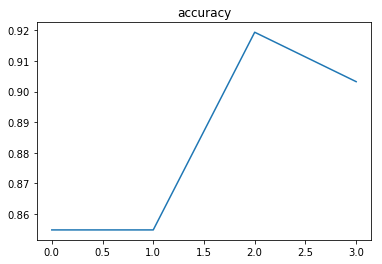

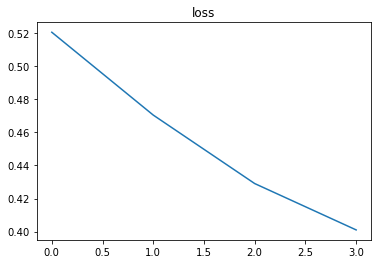

In [56]:
plt.plot(history.history['acc'])
plt.title('accuracy')
plt.show()
plt.plot(history.history['loss'])
plt.title('loss')
plt.show()

In [57]:
preds = model.predict(xTe_conv[te_idx, :, :, :])
(preds.flatten().round() == yTe_bin).mean()

1.0